# Clustering Crypto

In [56]:
# Initial imports
import requests
import os
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import hvplot.pandas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


%matplotlib inline

### Fetching Cryptocurrency Data

In [12]:
# Use the following endpoint to fetch json data
import json
import pprint
url = "https://min-api.cryptocompare.com/data/all/coinlist"
r=requests.get(url)
content=r.content
content_d=content.decode('utf-8')
data=json.loads(content_d)

In [13]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.
crypto_df = pd.DataFrame(data=data['Data'])

#Transpose Dataframe
crypto_df=crypto_df.transpose()
crypto_df.head(1)

,Id,Url,ImageUrl,ContentCreatedOn,Name,Symbol,CoinName,FullName,Description,AssetTokenStatus,...,MaxSupply,MktCapPenalty,IsUsedInDefi,IsUsedInNft,PlatformType,BuiltOn,SmartContractAddress,DecimalPoints,Difficulty,AlgorithmType
42,4321,/coins/42/overview,/media/35650717/42.jpg,1427211129,42,42,42 Coin,42 Coin (42),Everything about 42 coin is 42 - apart from th...,N/A,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame

### Data Preprocessing

In [14]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
# Reorder Columns that are still in the dataframe
crypto_df = crypto_df[['CoinName', 'Algorithm', 'IsTrading', 'ProofType', 'TotalCoinsMined', 'MaxSupply']]

crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,MaxSupply
42,42 Coin,Scrypt,True,PoW/PoS,0,0
300,300 token,N/A,True,N/A,300,300
365,365Coin,X11,True,PoW/PoS,0,0
404,404Coin,Scrypt,True,PoW/PoS,0,0
433,433 Token,N/A,False,N/A,NaN,NaN


In [15]:
# Keep only cryptocurrencies that are trading
crypto_df.drop(crypto_df[crypto_df['IsTrading'] == False].index,
              inplace=True)

In [16]:
# Keep only cryptocurrencies with a working algorithm
crypto_df.drop(crypto_df[crypto_df['Algorithm'] == 'N/A'].index, inplace=True)
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,MaxSupply
42,42 Coin,Scrypt,True,PoW/PoS,0,0
365,365Coin,X11,True,PoW/PoS,0,0
404,404Coin,Scrypt,True,PoW/PoS,0,0
611,SixEleven,SHA-256,True,PoW,0,0
808,808,SHA-256,True,PoW/PoS,0,0


In [17]:
# Remove the "IsTrading" column
crypto_df.drop(columns = ['IsTrading'], inplace=True)

In [18]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace=True)

In [19]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df.drop(crypto_df[crypto_df['TotalCoinsMined'] == 0].index, inplace=True)

In [20]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df != 'N/A'].dropna()

In [21]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
CoinName_df = crypto_df['CoinName'].to_frame()

In [22]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(columns = ['CoinName'], inplace=True)

In [23]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'], drop_first=True)

In [24]:
# Standardize data

X_scaled = StandardScaler().fit_transform(X)

### Reducing Dimensions Using PCA

In [25]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(X_scaled)

In [26]:
# Create a DataFrame with the principal components data
pca_df = pd.DataFrame(data=crypto_pca,
                            columns=['PC1', 'PC2', 'PC3'],
                            index=crypto_df.index
                            )
pca_df.head()

,PC1,PC2,PC3
NSR,-1.354455,0.724953,-0.615580
TRI,-1.547204,-0.876994,-0.457130
CMTC,0.695430,-0.784543,-0.273351
CHAT,-0.948252,-1.018266,-0.409246
QRL,1.271062,-0.593981,-0.146498


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [29]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
# set up a FOR loopy to run thru.. 
for i in k:
    km = KMeans(n_clusters=i, random_state=6)
    km.fit(pca_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

#elbow_df.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve Plot")

def line_plot(elbow_df):
    plt.plot(elbow_df)
    plt.ylabel('intertia')
    plt.show()

C:\Users\arghy\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


Running K-Means with `k=<your best value for k here>`

In [33]:
# Initialize the K-Means model
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
pca_df['class'] = model.labels_
pca_df.head()

,PC1,PC2,PC3,class
NSR,-1.354455,0.724953,-0.615580,0
TRI,-1.547204,-0.876994,-0.457130,0
CMTC,0.695430,-0.784543,-0.273351,1
CHAT,-0.948252,-1.018266,-0.409246,0
QRL,1.271062,-0.593981,-0.146498,1


### Visualizing Results

#### 3D-Scatter with Clusters

In [50]:
# Create a 3D-Scatter with the PCA data and the clusters
clustered_df = pd.concat([crypto_df, CoinName_df, pca_df], axis=1)
clustered_df.head()


,Algorithm,ProofType,TotalCoinsMined,MaxSupply,CoinName,PC1,PC2,PC3,class
NSR,PoS,PoS,6168428233.8311,0,NuShares,-1.354455,0.724953,-0.615580,0
TRI,X13,PoW/PoS,190058.370627,0,Triangles Coin,-1.547204,-0.876994,-0.457130,0
CMTC,Scrypt,PoW,872830,0,CometCoin,0.695430,-0.784543,-0.273351,1
CHAT,Scrypt,PoW/PoS,1000000000,-1,OpenChat,-0.948252,-1.018266,-0.409246,0
QRL,RandomX,PoW,75315588.121126,105000000,Quantum Resistant Ledger,1.271062,-0.593981,-0.146498,1


#### Table of Tradable Cryptocurrencies

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (1).

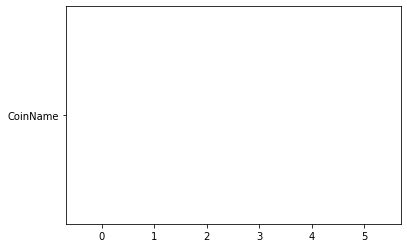

In [46]:
# Table with tradable cryptos
def clustered_df(numbers, labels, pos):
    plt.bar(pos, numbers, color='blue')
    plt.xticks(ticks=pos, labels=labels)
    plt.show()
if __name__ == '__main__':
    numbers = ['CoinName']
    labels = ['CoinName', 'Algorithm', 'ProofType', 'TotalCoinsMined', 'MaxSupply','class'],
    pos = list(range(6))
    clustered_df(numbers,labels, pos)
#clustered_df.hvplot.table(columns=['CoinName', 'Algorithm', 'ProofType', 'TotalCoinsMined', 'MaxSupply', 'class'], width=600)

In [51]:
# Print the total number of tradable cryptocurrencies
print(f'The total number of tradable cryptocurrenices is: {len(clustered_df)}')

The total number of tradable cryptocurrenices is: 128


#### Scatter Plot with Tradable Cryptocurrencies

In [52]:
# Scale data to create the scatter plot
scaler = MinMaxScaler()

normalize_columns = ['TotalCoinsMined', 'MaxSupply']
x = crypto_df[normalize_columns].values
x_scaled = scaler.fit_transform(x)

df_tradable = pd.DataFrame(x_scaled, columns=normalize_columns, index=crypto_df.index).reset_index()

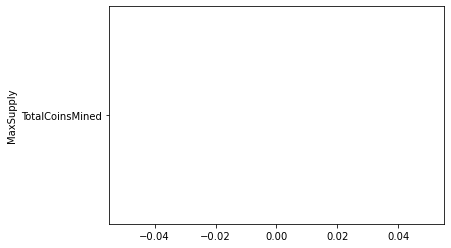

In [55]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"

#df_tradable.hvplot.scatter(x='TotalCoinsMined', y='MaxSupply',hover_cols=["CoinName"])
def line_plot(df_tradable):
    plt.plot(df_tradable)
    plt.ylabel('MaxSupply')
    plt.show()
if __name__ == '__main__':
    df_tradable = ['TotalCoinsMined']
    line_plot(df_tradable)